
# Extract USGS Gage Basin Polygon (NLDI) and Save as Shapefile — Site 05470500

This notebook uses the **USGS NLDI** (Hydrologic Network Linked Data Index) via the Python package **`pynhd`** to fetch the watershed **basin polygon** upstream of a USGS stream gage and saves it to a **Shapefile** for GIS use.

**What this does**
1. Install/import `pynhd` and `geopandas`.
2. Query NLDI for the **basin** of site **05470500**.
3. Reproject to a **projected CRS** for accurate area calculations.
4. Save to **ESRI Shapefile** (and optional GeoJSON), ready for your GitHub repo.
5. Quick map preview and area sanity check.


## 1) Install requirements (run once if needed)

In [1]:

# If needed in a fresh environment, uncomment:
# !pip install --upgrade pip
# !pip install pynhd geopandas shapely pyproj fiona


## 2) Parameters

In [2]:

from pathlib import Path

# USGS site number
SITE = "05470500"

# Output directory & filenames (Shapefile consists of multiple files with this stem)
OUT_DIR = Path("basin_shapefile")
OUT_STEM = f"basin_{SITE}"

# Optional: also write GeoJSON
WRITE_GEOJSON = True


## 3) Imports

In [3]:

import geopandas as gpd
from pynhd import NLDI
from pyproj import CRS
import warnings

warnings.filterwarnings("ignore", category=UserWarning)


## 4) Fetch basin polygon from NLDI

In [4]:

# NLDI client
nldi = NLDI()

# get_basins returns a GeoDataFrame of the upstream basin polygon for the site
basin_gdf = nldi.get_basins(SITE)

if basin_gdf is None or basin_gdf.empty:
    raise RuntimeError(f"No basin polygon returned by NLDI for site {SITE}. Check the site ID or NLDI availability.")

# Ensure WGS84 lon/lat for the raw geometry
basin_wgs84 = basin_gdf.to_crs(4326)
basin_wgs84.head()


,geometry
identifier,
USGS-05470500,"POLYGON ((-93.68428 42.0064, -93.68673 42.0089..."


## 5) Reproject to a projected CRS and compute area

In [5]:

# For CONUS, EPSG:5070 (NAD83 / Conus Albers) is a good equal-area choice
proj_crs = CRS.from_epsg(5070)
basin_proj = basin_wgs84.to_crs(proj_crs)

# Compute area in square kilometers for a quick check
basin_proj["area_km2"] = basin_proj.geometry.area / 1e6
basin_proj[["area_km2"]]


,area_km2
identifier,
USGS-05470500,548.408129


## 6) Save to Shapefile (and optional GeoJSON)

In [6]:

OUT_DIR.mkdir(parents=True, exist_ok=True)

# Shapefile path (multiple sidecar files with this stem will be created)
shp_path = OUT_DIR / f"{OUT_STEM}.shp"
basin_proj.to_file(shp_path, driver="ESRI Shapefile")
print("Saved Shapefile to:", shp_path.resolve())

if WRITE_GEOJSON:
    geojson_path = OUT_DIR / f"{OUT_STEM}.geojson"
    basin_wgs84.to_file(geojson_path, driver="GeoJSON")  # keep GeoJSON in WGS84
    print("Saved GeoJSON to:", geojson_path.resolve())


Saved Shapefile to: D:\Desktop-OneDrive\OpenET_Paper\GitHub\basin_shapefile\basin_05470500.shp
Saved GeoJSON to: D:\Desktop-OneDrive\OpenET_Paper\GitHub\basin_shapefile\basin_05470500.geojson


## 7) Quick map preview

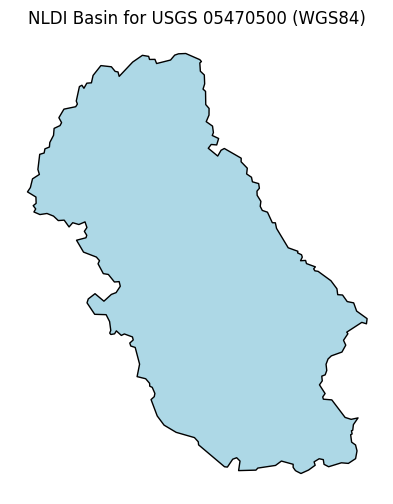

In [7]:

ax = basin_wgs84.plot(figsize=(6, 6), edgecolor='k', facecolor='lightblue')
ax.set_title(f"NLDI Basin for USGS {SITE} (WGS84)")
ax.set_axis_off()



## 8) Notes & Tips
- **Why EPSG:5070?** It's an equal-area projection suitable for CONUS; area calculations in meters² are reliable.  
- **Local CRS:** For engineering design, you may reproject to a local UTM zone (`EPSG:26915` for Iowa UTM 15N is common).  
- **Attributes:** NLDI typically includes basic metadata; you can add your own fields (e.g., `site_no`, `name`).  
- **Automation:** Wrap these steps into a script for batch processi and the corresponding repository
